#Intro

In [ ]:
# https://youtu.be/AP0A8PgYfro
# https://youtu.be/mjftYIKSlLQ
"""
Semi-supervised GAN (SGAN)

Semi-supervised refers to the training process where the model gets trained only
on a few labeled images but the data set contains a lot more unlabeled images.
This can be useful in situations where you have a humongous data set but only
partially labeled.

In regular GAN the discriminator is trained in an unsupervised manner, where it
predicts whether the image is real or fake (binary classification).
In SGAN, in addition to unsupervised, the discriminator gets trained in a
supervised manner on class labels for real images (multiclass classification).

In essence, the unsupervised mode trains the discriminator to learn features and
the supervised mode trains on corresponding classes (labels). The GAN
can be trained using only a handful of labeled examples.

In a standard GAN our focus is on training a generator that we want to use to generate
fake images. In SGAN, our goal is to train the discriminator to be an excellent classifier
using only a few labeled images. We can still use the generator to generate fake images but
our focus is on the discriminator.

Why do we want to follow this path is CNNs can easily classify images?
Apparently, this approach achieves better accuracy for limited labeled data compared to CNNs.
(https://arxiv.org/abs/1606.01583)

Another useful resource: https://arxiv.org/pdf/1606.03498.pdf​
"""


#Packages

In [ ]:
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint
import os
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation

#from keras.utils import to_categorical

from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

data_shape=(32,32,3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/SGAN PROJECT")
save_dir = os.path.join(os.getcwd(), 'saved_models')
fig_dir = os.path.join(os.getcwd(), 'saved_figs')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Generator

In [ ]:
def define_generator(latent_dim,target_dim=data_shape):
  if target_dim ==(28,28,1)or target_dim ==(32,32,3):
    target_a,target_b,target_c=target_dim
  else:
    raise Exception

  in_lat = Input(shape=(latent_dim,))
  n_nodes = target_a//4*target_b//4*256 #Start with enough dense nodes to be reshaped and ConvTransposed to 28x28x1
  X = Dense(n_nodes)(in_lat)
  X = LeakyReLU(alpha=0.2)(X)

  X = Reshape((target_a//4, target_b//4, 256))(X)

  X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #14x14x128
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #14x14x64
  X = LeakyReLU(alpha=0.2)(X)
  # output
  out_layer = Conv2DTranspose(target_c, (3,3), strides=(2,2), activation='tanh',
                              padding='same')(X) #28x28xtarget_c
  # define model
  model = Model(in_lat, out_layer)
  return model


#Discriminator

In [ ]:
def define_discriminator(in_shape=data_shape, n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data.
    X = Dense(n_classes)(X)

    model = Model(inputs=in_image, outputs=X)

    return model


#Supervised discriminator

In [ ]:
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #Let us use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

#custom activation function for unsupervised discriminator



In [ ]:
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)

    return D_x

#Unsupervised discriminator

In [ ]:
def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model


#The GAN

In [ ]:
def define_gan(gen_model, disc_unsup):

	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model


#loading images

In [ ]:
def load_real_samples(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation.
    print(X.shape, trainy.shape)
    return [X, trainy]


#selection of supervised samples

In [ ]:
def select_supervised_samples(dataset, n_samples=1000, n_classes=10):
	X, y = dataset
	y=y.flatten()
	X_list, y_list = list(), list()
	# print('X',X,X.shape)
	# print('y',y,y.shape)
	n_per_class = int(n_samples / n_classes) #Number of samples per class.
	for i in range(n_classes):
					X_with_class = X[y == i] # get all images for this class
					ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
					[X_list.append(X_with_class[j]) for j in ix] # add to list
					[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y


#generate real samples

In [ ]:
def generate_real_samples(dataset, n_samples):

	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training)
	return [X, labels], y


#generate latent points

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input


#generate fake samples

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training)
	return fake_images, y

#Performance

In [ ]:
# report accuracy and save plots & the model periodically.
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	# evaluate the discriminator
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))


#Training of generator and discriminator

In [ ]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):

    # select supervised dataset for training.
    #Remember that we are not using all 60k images, just a subset (100 images, 10 per class. )
	X_sup, y_sup = select_supervised_samples(dataset)
	#print(X_sup.shape, y_sup.shape)

	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs

	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs,
                                                              n_batch, half_batch,
                                                              bat_per_epo, n_steps))

    #  enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples.
        #Remember that we use real labels to train as this is supervised.
        #This is the discriminator we really care about at the end.
        #Also, this is a multiclass classifier, not binary. Therefore, our y values
        #will be the real class labels for MNIST. (NOT 1 or 0 indicating real or fake.)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)

		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
        #Remember that we will not train on labels as this is unsupervised, just binary as in our regular GAN.
        #The y_real below indicates 1s telling the discriminator that these images are real.
        #do not confuse this with class labels.
        #We will discard this discriminator at the end.
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
        #Now train on fake.
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)

		# update generator (gen) - like we do in regular GAN.
        #We can discard this model at the end as our primary goal is to train a multiclass classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)

		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

#actual training

In [ ]:
latent_dim = 100

# create the discriminator models
disc=define_discriminator() #Bare discriminator model...
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model.

gen_model = define_generator(latent_dim,target_dim=data_shape) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)

# train the model
# NOTE: 1 epoch = 600 steps in this example.
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=100, n_batch=100)

(50000, 32, 32, 3, 1) (50000, 1)
n_epochs=100, n_batch=100, 1/2=50, b/e=500, steps=50000
2/2 [==============================] - 0s 4ms/step
>1, c[2.313,10], d[0.097,2.406], g[0.095]
2/2 [==============================] - 0s 4ms/step
>2, c[2.276,8], d[0.089,2.403], g[0.096]
2/2 [==============================] - 0s 4ms/step
>3, c[2.265,20], d[0.087,2.399], g[0.096]
2/2 [==============================] - 0s 3ms/step
>4, c[2.227,20], d[0.078,2.410], g[0.097]
2/2 [==============================] - 0s 4ms/step
>5, c[2.258,16], d[0.064,2.384], g[0.103]
2/2 [==============================] - 0s 4ms/step
>6, c[2.193,18], d[0.053,2.332], g[0.110]
2/2 [==============================] - 0s 4ms/step
>7, c[2.237,16], d[0.035,2.314], g[0.115]
2/2 [==============================] - 0s 4ms/step
>8, c[2.358,22], d[0.022,2.306], g[0.124]
2/2 [==============================] - 0s 4ms/step
>9, c[2.319,18], d[0.019,2.268], g[0.149]
2/2 [==============================] - 0s 4ms/step
>10, c[2.071,26], d[0.02

Discriminator Accuracy: 42.268%
>Saved: generated_plot_0500.png, gen_model_0500.h5, and disc_sup_0500.h5
2/2 [==============================] - 0s 3ms/step
>501, c[0.957,64], d[0.797,1.107], g[0.720]
2/2 [==============================] - 0s 4ms/step
>502, c[0.846,82], d[0.804,1.006], g[0.751]
2/2 [==============================] - 0s 4ms/step
>503, c[0.915,68], d[0.745,1.041], g[0.815]
2/2 [==============================] - 0s 4ms/step
>504, c[0.970,60], d[0.800,0.852], g[0.982]
2/2 [==============================] - 0s 3ms/step
>505, c[0.814,76], d[0.877,0.750], g[0.965]
2/2 [==============================] - 0s 3ms/step
>506, c[0.992,66], d[0.908,0.922], g[0.850]
2/2 [==============================] - 0s 4ms/step
>507, c[1.193,58], d[0.745,0.854], g[1.016]
2/2 [==============================] - 0s 4ms/step
>508, c[1.235,68], d[0.749,0.895], g[1.126]
2/2 [==============================] - 0s 4ms/step
>509, c[1.047,68], d[0.753,0.723], g[1.068]
2/2 [==============================] - 0

Discriminator Accuracy: 39.900%
>Saved: generated_plot_1000.png, gen_model_1000.h5, and disc_sup_1000.h5
2/2 [==============================] - 0s 4ms/step
>1001, c[0.666,80], d[0.774,0.747], g[0.976]
2/2 [==============================] - 0s 3ms/step
>1002, c[0.652,82], d[0.755,1.043], g[0.878]
2/2 [==============================] - 0s 3ms/step
>1003, c[0.629,84], d[0.817,0.932], g[0.778]
2/2 [==============================] - 0s 4ms/step
>1004, c[0.627,80], d[0.844,1.071], g[0.716]
2/2 [==============================] - 0s 3ms/step
>1005, c[0.561,88], d[0.697,0.975], g[0.628]
2/2 [==============================] - 0s 4ms/step
>1006, c[0.468,90], d[0.778,0.902], g[0.716]
2/2 [==============================] - 0s 5ms/step
>1007, c[0.721,80], d[0.796,0.953], g[0.842]
2/2 [==============================] - 0s 3ms/step
>1008, c[0.542,88], d[0.807,0.833], g[0.872]
2/2 [==============================] - 0s 4ms/step
>1009, c[0.647,86], d[0.833,1.035], g[0.876]
2/2 [==========================

Discriminator Accuracy: 39.424%
>Saved: generated_plot_1500.png, gen_model_1500.h5, and disc_sup_1500.h5
2/2 [==============================] - 0s 4ms/step
>1501, c[0.347,90], d[0.984,0.947], g[0.787]
2/2 [==============================] - 0s 4ms/step
>1502, c[0.453,88], d[1.001,1.007], g[0.585]
2/2 [==============================] - 0s 4ms/step
>1503, c[0.476,90], d[0.830,1.022], g[0.655]
2/2 [==============================] - 0s 3ms/step
>1504, c[0.349,94], d[0.810,0.962], g[0.838]
2/2 [==============================] - 0s 4ms/step
>1505, c[0.484,90], d[0.846,0.885], g[0.892]
2/2 [==============================] - 0s 4ms/step
>1506, c[0.394,92], d[0.830,0.710], g[0.922]
2/2 [==============================] - 0s 4ms/step
>1507, c[0.321,96], d[0.663,0.932], g[0.838]
2/2 [==============================] - 0s 3ms/step
>1508, c[0.390,92], d[0.775,0.931], g[0.754]
2/2 [==============================] - 0s 4ms/step
>1509, c[0.390,94], d[0.788,0.999], g[0.720]
2/2 [==========================

Discriminator Accuracy: 36.534%
>Saved: generated_plot_2000.png, gen_model_2000.h5, and disc_sup_2000.h5
2/2 [==============================] - 0s 4ms/step
>2001, c[0.286,92], d[0.838,0.806], g[0.793]
2/2 [==============================] - 0s 4ms/step
>2002, c[0.349,94], d[0.848,1.029], g[0.902]
2/2 [==============================] - 0s 4ms/step
>2003, c[0.435,84], d[0.833,0.790], g[0.904]
2/2 [==============================] - 0s 4ms/step
>2004, c[0.300,94], d[0.757,0.788], g[0.884]
2/2 [==============================] - 0s 4ms/step
>2005, c[0.327,92], d[0.840,0.823], g[0.700]
2/2 [==============================] - 0s 3ms/step
>2006, c[0.412,90], d[0.734,0.859], g[0.740]
2/2 [==============================] - 0s 3ms/step
>2007, c[0.338,96], d[0.749,1.026], g[0.761]
2/2 [==============================] - 0s 4ms/step
>2008, c[0.345,92], d[0.857,0.962], g[0.734]
2/2 [==============================] - 0s 4ms/step
>2009, c[0.371,92], d[0.946,1.037], g[0.816]
2/2 [==========================

Discriminator Accuracy: 36.418%
>Saved: generated_plot_2500.png, gen_model_2500.h5, and disc_sup_2500.h5
2/2 [==============================] - 0s 4ms/step
>2501, c[0.192,98], d[0.722,0.918], g[0.760]
2/2 [==============================] - 0s 4ms/step
>2502, c[0.285,94], d[0.727,0.956], g[0.936]
2/2 [==============================] - 0s 3ms/step
>2503, c[0.340,90], d[0.927,0.811], g[0.851]
2/2 [==============================] - 0s 3ms/step
>2504, c[0.378,84], d[0.793,0.974], g[0.883]
2/2 [==============================] - 0s 5ms/step
>2505, c[0.227,90], d[0.760,1.041], g[0.838]
2/2 [==============================] - 0s 4ms/step
>2506, c[0.450,88], d[0.771,0.781], g[0.883]
2/2 [==============================] - 0s 4ms/step
>2507, c[0.175,98], d[0.767,0.900], g[0.860]
2/2 [==============================] - 0s 5ms/step
>2508, c[0.286,96], d[0.847,0.855], g[0.852]
2/2 [==============================] - 0s 4ms/step
>2509, c[0.397,86], d[0.917,0.863], g[0.802]
2/2 [==========================

Discriminator Accuracy: 36.482%
>Saved: generated_plot_3000.png, gen_model_3000.h5, and disc_sup_3000.h5
2/2 [==============================] - 0s 4ms/step
>3001, c[0.242,96], d[0.878,1.173], g[0.794]
2/2 [==============================] - 0s 4ms/step
>3002, c[0.191,98], d[0.833,0.991], g[0.850]
2/2 [==============================] - 0s 4ms/step
>3003, c[0.388,92], d[0.815,0.847], g[0.875]
2/2 [==============================] - 0s 4ms/step
>3004, c[0.239,96], d[0.842,1.037], g[0.939]
2/2 [==============================] - 0s 4ms/step
>3005, c[0.180,98], d[0.821,0.785], g[0.988]
2/2 [==============================] - 0s 3ms/step
>3006, c[0.206,96], d[0.758,0.852], g[0.867]
2/2 [==============================] - 0s 4ms/step
>3007, c[0.181,98], d[0.762,1.120], g[0.901]
2/2 [==============================] - 0s 3ms/step
>3008, c[0.163,96], d[0.895,1.010], g[0.757]
2/2 [==============================] - 0s 4ms/step
>3009, c[0.244,98], d[0.838,0.972], g[0.790]
2/2 [==========================

Discriminator Accuracy: 38.314%
>Saved: generated_plot_3500.png, gen_model_3500.h5, and disc_sup_3500.h5
2/2 [==============================] - 0s 4ms/step
>3501, c[0.162,98], d[0.818,0.767], g[0.826]
2/2 [==============================] - 0s 4ms/step
>3502, c[0.145,98], d[0.857,0.936], g[0.809]
2/2 [==============================] - 0s 4ms/step
>3503, c[0.340,90], d[0.921,0.951], g[0.744]
2/2 [==============================] - 0s 3ms/step
>3504, c[0.139,98], d[0.885,0.961], g[0.843]
2/2 [==============================] - 0s 4ms/step
>3505, c[0.205,100], d[0.849,0.934], g[0.798]
2/2 [==============================] - 0s 4ms/step
>3506, c[0.216,98], d[0.816,1.039], g[0.739]
2/2 [==============================] - 0s 3ms/step
>3507, c[0.175,94], d[0.766,1.051], g[0.737]
2/2 [==============================] - 0s 3ms/step
>3508, c[0.208,94], d[0.780,0.935], g[0.775]
2/2 [==============================] - 0s 4ms/step
>3509, c[0.132,98], d[0.710,0.798], g[0.802]
2/2 [=========================

Discriminator Accuracy: 36.328%
>Saved: generated_plot_4000.png, gen_model_4000.h5, and disc_sup_4000.h5
2/2 [==============================] - 0s 4ms/step
>4001, c[0.192,96], d[0.817,1.152], g[0.840]
2/2 [==============================] - 0s 5ms/step
>4002, c[0.130,100], d[0.806,1.001], g[0.803]
2/2 [==============================] - 0s 4ms/step
>4003, c[0.169,96], d[0.701,0.850], g[0.825]
2/2 [==============================] - 0s 4ms/step
>4004, c[0.181,96], d[0.928,0.704], g[0.753]
2/2 [==============================] - 0s 4ms/step
>4005, c[0.094,100], d[0.909,0.841], g[0.727]
2/2 [==============================] - 0s 5ms/step
>4006, c[0.118,100], d[0.714,1.126], g[0.806]
2/2 [==============================] - 0s 4ms/step
>4007, c[0.194,94], d[0.758,0.974], g[0.765]
2/2 [==============================] - 0s 4ms/step
>4008, c[0.214,98], d[0.868,0.897], g[0.800]
2/2 [==============================] - 0s 4ms/step
>4009, c[0.161,100], d[1.011,0.821], g[0.796]
2/2 [======================

Discriminator Accuracy: 36.424%
>Saved: generated_plot_4500.png, gen_model_4500.h5, and disc_sup_4500.h5
2/2 [==============================] - 0s 4ms/step
>4501, c[0.145,98], d[0.793,0.717], g[0.747]
2/2 [==============================] - 0s 4ms/step
>4502, c[0.176,96], d[0.852,1.074], g[0.856]
2/2 [==============================] - 0s 4ms/step
>4503, c[0.238,94], d[0.716,0.855], g[0.841]
2/2 [==============================] - 0s 3ms/step
>4504, c[0.103,100], d[0.826,0.904], g[0.836]
2/2 [==============================] - 0s 4ms/step
>4505, c[0.158,96], d[0.725,0.922], g[0.777]
2/2 [==============================] - 0s 4ms/step
>4506, c[0.200,98], d[0.853,0.816], g[0.961]
2/2 [==============================] - 0s 3ms/step
>4507, c[0.232,98], d[0.770,0.706], g[0.913]
2/2 [==============================] - 0s 4ms/step
>4508, c[0.072,98], d[0.817,0.722], g[0.881]
2/2 [==============================] - 0s 4ms/step
>4509, c[0.153,98], d[0.750,1.001], g[0.788]
2/2 [=========================

Discriminator Accuracy: 36.836%
>Saved: generated_plot_5000.png, gen_model_5000.h5, and disc_sup_5000.h5
2/2 [==============================] - 0s 3ms/step
>5001, c[0.124,100], d[1.003,0.757], g[0.854]
2/2 [==============================] - 0s 3ms/step
>5002, c[0.159,96], d[0.720,0.813], g[0.853]
2/2 [==============================] - 0s 3ms/step
>5003, c[0.078,100], d[0.809,0.933], g[0.805]
2/2 [==============================] - 0s 4ms/step
>5004, c[0.145,98], d[0.854,1.001], g[0.798]
2/2 [==============================] - 0s 4ms/step
>5005, c[0.125,100], d[0.775,0.830], g[0.844]
2/2 [==============================] - 0s 4ms/step
>5006, c[0.146,96], d[1.002,0.906], g[0.777]
2/2 [==============================] - 0s 3ms/step
>5007, c[0.130,100], d[0.845,0.807], g[0.969]
2/2 [==============================] - 0s 4ms/step
>5008, c[0.185,96], d[0.875,0.668], g[1.012]
2/2 [==============================] - 0s 3ms/step
>5009, c[0.126,98], d[0.700,0.828], g[0.818]
2/2 [======================

Discriminator Accuracy: 33.890%
>Saved: generated_plot_5500.png, gen_model_5500.h5, and disc_sup_5500.h5
2/2 [==============================] - 0s 4ms/step
>5501, c[0.190,96], d[0.909,1.017], g[0.957]
2/2 [==============================] - 0s 4ms/step
>5502, c[0.101,98], d[0.764,1.026], g[0.978]
2/2 [==============================] - 0s 4ms/step
>5503, c[0.187,98], d[0.818,1.023], g[0.823]
2/2 [==============================] - 0s 4ms/step
>5504, c[0.126,100], d[0.825,0.991], g[0.823]
2/2 [==============================] - 0s 4ms/step
>5505, c[0.141,96], d[0.846,0.738], g[0.944]
2/2 [==============================] - 0s 4ms/step
>5506, c[0.084,100], d[0.770,0.764], g[0.842]
2/2 [==============================] - 0s 4ms/step
>5507, c[0.093,100], d[0.799,0.715], g[0.818]
2/2 [==============================] - 0s 3ms/step
>5508, c[0.226,96], d[0.763,0.955], g[0.876]
2/2 [==============================] - 0s 4ms/step
>5509, c[0.241,94], d[0.693,0.902], g[0.816]
2/2 [=======================

Discriminator Accuracy: 35.756%
>Saved: generated_plot_6000.png, gen_model_6000.h5, and disc_sup_6000.h5
2/2 [==============================] - 0s 4ms/step
>6001, c[0.124,98], d[0.879,1.054], g[0.858]
2/2 [==============================] - 0s 3ms/step
>6002, c[0.232,92], d[0.779,1.077], g[0.793]
2/2 [==============================] - 0s 4ms/step
>6003, c[0.105,100], d[0.798,0.767], g[0.737]
2/2 [==============================] - 0s 3ms/step
>6004, c[0.140,100], d[0.801,1.124], g[0.735]
2/2 [==============================] - 0s 4ms/step
>6005, c[0.114,98], d[0.731,1.041], g[0.842]
2/2 [==============================] - 0s 3ms/step
>6006, c[0.188,98], d[0.810,1.000], g[0.840]
2/2 [==============================] - 0s 3ms/step
>6007, c[0.150,96], d[0.772,0.937], g[0.806]
2/2 [==============================] - 0s 4ms/step
>6008, c[0.172,96], d[0.780,0.966], g[0.839]
2/2 [==============================] - 0s 3ms/step
>6009, c[0.115,98], d[0.803,1.025], g[0.873]
2/2 [========================

Discriminator Accuracy: 33.300%
>Saved: generated_plot_6500.png, gen_model_6500.h5, and disc_sup_6500.h5
2/2 [==============================] - 0s 4ms/step
>6501, c[0.169,98], d[0.938,0.906], g[0.824]
2/2 [==============================] - 0s 4ms/step
>6502, c[0.176,98], d[0.734,0.844], g[0.906]
2/2 [==============================] - 0s 4ms/step
>6503, c[0.167,96], d[0.793,0.932], g[0.814]
2/2 [==============================] - 0s 4ms/step
>6504, c[0.073,100], d[0.875,0.851], g[0.850]
2/2 [==============================] - 0s 4ms/step
>6505, c[0.122,98], d[0.725,0.944], g[0.943]
2/2 [==============================] - 0s 5ms/step
>6506, c[0.100,100], d[0.959,0.780], g[0.966]
2/2 [==============================] - 0s 4ms/step
>6507, c[0.118,98], d[0.815,0.906], g[0.897]
2/2 [==============================] - 0s 4ms/step
>6508, c[0.128,98], d[0.994,0.990], g[0.855]
2/2 [==============================] - 0s 4ms/step
>6509, c[0.145,96], d[0.930,0.689], g[0.860]
2/2 [========================

Discriminator Accuracy: 34.580%
>Saved: generated_plot_7000.png, gen_model_7000.h5, and disc_sup_7000.h5
2/2 [==============================] - 0s 4ms/step
>7001, c[0.130,96], d[0.670,0.880], g[0.723]
2/2 [==============================] - 0s 3ms/step
>7002, c[0.125,98], d[0.687,1.036], g[0.869]
2/2 [==============================] - 0s 3ms/step
>7003, c[0.137,98], d[0.905,0.744], g[0.853]
2/2 [==============================] - 0s 4ms/step
>7004, c[0.158,100], d[0.753,0.972], g[0.803]
2/2 [==============================] - 0s 3ms/step
>7005, c[0.074,100], d[0.790,0.938], g[0.949]
2/2 [==============================] - 0s 3ms/step
>7006, c[0.160,98], d[0.906,0.883], g[0.868]
2/2 [==============================] - 0s 4ms/step
>7007, c[0.130,96], d[0.839,0.930], g[0.838]
2/2 [==============================] - 0s 4ms/step
>7008, c[0.229,94], d[0.856,1.004], g[0.889]
2/2 [==============================] - 0s 4ms/step
>7009, c[0.088,100], d[0.825,0.976], g[0.950]
2/2 [=======================

Discriminator Accuracy: 34.502%
>Saved: generated_plot_7500.png, gen_model_7500.h5, and disc_sup_7500.h5
2/2 [==============================] - 0s 4ms/step
>7501, c[0.107,100], d[0.886,0.770], g[0.780]
2/2 [==============================] - 0s 4ms/step
>7502, c[0.164,98], d[0.920,0.717], g[0.857]
2/2 [==============================] - 0s 3ms/step
>7503, c[0.146,96], d[0.750,0.980], g[0.878]
2/2 [==============================] - 0s 4ms/step
>7504, c[0.108,100], d[0.854,0.948], g[0.718]
2/2 [==============================] - 0s 3ms/step
>7505, c[0.080,100], d[0.973,1.083], g[0.774]
2/2 [==============================] - 0s 3ms/step
>7506, c[0.136,96], d[0.807,1.136], g[0.700]
2/2 [==============================] - 0s 3ms/step
>7507, c[0.085,98], d[0.629,1.057], g[0.880]
2/2 [==============================] - 0s 3ms/step
>7508, c[0.198,96], d[0.711,1.066], g[0.891]
2/2 [==============================] - 0s 3ms/step
>7509, c[0.074,100], d[0.807,0.878], g[0.925]
2/2 [======================

Discriminator Accuracy: 32.592%
>Saved: generated_plot_8000.png, gen_model_8000.h5, and disc_sup_8000.h5
2/2 [==============================] - 0s 4ms/step
>8001, c[0.177,96], d[0.847,0.786], g[0.975]
2/2 [==============================] - 0s 4ms/step
>8002, c[0.144,98], d[0.778,1.007], g[0.902]
2/2 [==============================] - 0s 4ms/step
>8003, c[0.165,98], d[0.729,0.814], g[1.096]
2/2 [==============================] - 0s 4ms/step
>8004, c[0.152,96], d[1.038,0.905], g[0.906]
2/2 [==============================] - 0s 4ms/step
>8005, c[0.074,100], d[0.887,1.072], g[1.003]
2/2 [==============================] - 0s 4ms/step
>8006, c[0.129,98], d[0.895,0.862], g[0.956]
2/2 [==============================] - 0s 4ms/step
>8007, c[0.215,96], d[0.813,0.896], g[0.899]
2/2 [==============================] - 0s 4ms/step
>8008, c[0.110,98], d[0.935,0.935], g[0.755]
2/2 [==============================] - 0s 4ms/step
>8009, c[0.115,98], d[0.879,0.964], g[0.735]
2/2 [=========================

Discriminator Accuracy: 34.974%
>Saved: generated_plot_8500.png, gen_model_8500.h5, and disc_sup_8500.h5
2/2 [==============================] - 0s 4ms/step
>8501, c[0.152,96], d[0.999,0.920], g[0.875]
2/2 [==============================] - 0s 4ms/step
>8502, c[0.087,98], d[1.064,0.799], g[0.856]
2/2 [==============================] - 0s 3ms/step
>8503, c[0.144,96], d[0.798,0.756], g[0.882]
2/2 [==============================] - 0s 3ms/step
>8504, c[0.113,100], d[0.654,0.950], g[0.874]
2/2 [==============================] - 0s 4ms/step
>8505, c[0.063,100], d[0.692,0.936], g[0.802]
2/2 [==============================] - 0s 4ms/step
>8506, c[0.132,96], d[0.855,1.159], g[0.678]
2/2 [==============================] - 0s 3ms/step
>8507, c[0.139,98], d[0.796,0.926], g[0.790]
2/2 [==============================] - 0s 4ms/step
>8508, c[0.190,96], d[0.797,1.133], g[0.871]
2/2 [==============================] - 0s 3ms/step
>8509, c[0.112,98], d[0.685,0.735], g[0.884]
2/2 [========================

Discriminator Accuracy: 34.378%
>Saved: generated_plot_9000.png, gen_model_9000.h5, and disc_sup_9000.h5
2/2 [==============================] - 0s 4ms/step
>9001, c[0.168,96], d[0.926,0.803], g[0.868]
2/2 [==============================] - 0s 4ms/step
>9002, c[0.104,98], d[0.823,0.950], g[0.969]
2/2 [==============================] - 0s 4ms/step
>9003, c[0.137,98], d[1.034,0.948], g[0.772]
2/2 [==============================] - 0s 4ms/step
>9004, c[0.130,98], d[0.717,1.056], g[0.818]
2/2 [==============================] - 0s 4ms/step
>9005, c[0.073,100], d[0.840,1.038], g[0.818]
2/2 [==============================] - 0s 3ms/step
>9006, c[0.111,98], d[0.932,1.100], g[0.777]
2/2 [==============================] - 0s 3ms/step
>9007, c[0.160,98], d[0.925,0.985], g[0.743]
2/2 [==============================] - 0s 3ms/step
>9008, c[0.065,100], d[0.789,1.004], g[0.927]
2/2 [==============================] - 0s 4ms/step
>9009, c[0.124,94], d[0.622,0.922], g[1.096]
2/2 [========================

Discriminator Accuracy: 32.904%
>Saved: generated_plot_9500.png, gen_model_9500.h5, and disc_sup_9500.h5
2/2 [==============================] - 0s 4ms/step
>9501, c[0.140,94], d[0.843,0.717], g[0.929]
2/2 [==============================] - 0s 3ms/step
>9502, c[0.132,98], d[0.741,1.169], g[0.945]
2/2 [==============================] - 0s 4ms/step
>9503, c[0.068,100], d[1.042,0.922], g[0.982]
2/2 [==============================] - 0s 4ms/step
>9504, c[0.089,98], d[0.986,0.841], g[0.968]
2/2 [==============================] - 0s 4ms/step
>9505, c[0.082,100], d[0.898,0.995], g[0.963]
2/2 [==============================] - 0s 3ms/step
>9506, c[0.056,100], d[0.715,0.749], g[1.141]
2/2 [==============================] - 0s 4ms/step
>9507, c[0.211,92], d[0.935,0.917], g[0.838]
2/2 [==============================] - 0s 4ms/step
>9508, c[0.095,98], d[0.882,1.200], g[0.723]
2/2 [==============================] - 0s 4ms/step
>9509, c[0.078,100], d[0.904,0.937], g[0.813]
2/2 [======================

Discriminator Accuracy: 33.250%
>Saved: generated_plot_10000.png, gen_model_10000.h5, and disc_sup_10000.h5
2/2 [==============================] - 0s 4ms/step
>10001, c[0.133,98], d[0.797,0.899], g[0.854]
2/2 [==============================] - 0s 3ms/step
>10002, c[0.183,96], d[0.773,0.902], g[0.850]
2/2 [==============================] - 0s 4ms/step
>10003, c[0.211,94], d[0.816,1.116], g[0.900]
2/2 [==============================] - 0s 4ms/step
>10004, c[0.101,98], d[1.057,0.896], g[0.843]
2/2 [==============================] - 0s 4ms/step
>10005, c[0.107,98], d[0.711,1.053], g[0.855]
2/2 [==============================] - 0s 4ms/step
>10006, c[0.093,98], d[0.729,0.910], g[1.150]
2/2 [==============================] - 0s 4ms/step
>10007, c[0.080,100], d[0.763,0.827], g[0.845]
2/2 [==============================] - 0s 3ms/step
>10008, c[0.162,96], d[0.881,0.911], g[0.794]
2/2 [==============================] - 0s 4ms/step
>10009, c[0.097,100], d[0.715,1.032], g[0.893]
2/2 [============

Discriminator Accuracy: 32.452%
>Saved: generated_plot_10500.png, gen_model_10500.h5, and disc_sup_10500.h5
2/2 [==============================] - 0s 4ms/step
>10501, c[0.107,98], d[0.960,0.884], g[0.948]
2/2 [==============================] - 0s 4ms/step
>10502, c[0.170,96], d[0.787,1.008], g[0.898]
2/2 [==============================] - 0s 4ms/step
>10503, c[0.080,100], d[0.851,1.135], g[0.944]
2/2 [==============================] - 0s 4ms/step
>10504, c[0.083,100], d[0.946,0.724], g[0.900]
2/2 [==============================] - 0s 4ms/step
>10505, c[0.152,94], d[0.949,1.108], g[0.923]
2/2 [==============================] - 0s 4ms/step
>10506, c[0.051,100], d[0.807,0.920], g[0.826]
2/2 [==============================] - 0s 4ms/step
>10507, c[0.200,96], d[0.877,0.789], g[0.908]
2/2 [==============================] - 0s 4ms/step
>10508, c[0.145,96], d[0.738,1.088], g[0.896]
2/2 [==============================] - 0s 4ms/step
>10509, c[0.108,98], d[0.796,0.701], g[1.007]
2/2 [===========

Discriminator Accuracy: 34.666%
>Saved: generated_plot_11000.png, gen_model_11000.h5, and disc_sup_11000.h5
2/2 [==============================] - 0s 4ms/step
>11001, c[0.120,98], d[0.941,1.199], g[0.874]
2/2 [==============================] - 0s 4ms/step
>11002, c[0.218,96], d[0.894,0.848], g[1.081]
2/2 [==============================] - 0s 4ms/step
>11003, c[0.113,96], d[0.700,1.128], g[0.905]
2/2 [==============================] - 0s 4ms/step
>11004, c[0.064,100], d[0.821,0.831], g[1.009]
2/2 [==============================] - 0s 4ms/step
>11005, c[0.104,98], d[0.774,0.992], g[0.993]
2/2 [==============================] - 0s 4ms/step
>11006, c[0.072,100], d[0.917,0.962], g[1.125]
2/2 [==============================] - 0s 4ms/step
>11007, c[0.137,96], d[0.824,0.806], g[0.836]
2/2 [==============================] - 0s 4ms/step
>11008, c[0.050,100], d[0.884,1.102], g[0.893]
2/2 [==============================] - 0s 4ms/step
>11009, c[0.173,98], d[0.835,0.853], g[0.927]
2/2 [===========

Discriminator Accuracy: 30.822%
>Saved: generated_plot_11500.png, gen_model_11500.h5, and disc_sup_11500.h5
2/2 [==============================] - 0s 3ms/step
>11501, c[0.176,96], d[0.814,0.897], g[0.940]
2/2 [==============================] - 0s 3ms/step
>11502, c[0.178,96], d[0.926,0.809], g[0.888]
2/2 [==============================] - 0s 4ms/step
>11503, c[0.217,96], d[1.045,0.938], g[0.871]
2/2 [==============================] - 0s 4ms/step
>11504, c[0.089,98], d[0.813,1.049], g[0.907]
2/2 [==============================] - 0s 4ms/step
>11505, c[0.090,98], d[0.930,1.017], g[1.011]
2/2 [==============================] - 0s 3ms/step
>11506, c[0.154,96], d[0.695,0.841], g[0.910]
2/2 [==============================] - 0s 4ms/step
>11507, c[0.111,100], d[0.999,0.985], g[1.030]
2/2 [==============================] - 0s 4ms/step
>11508, c[0.100,98], d[0.879,0.868], g[1.005]
2/2 [==============================] - 0s 3ms/step
>11509, c[0.131,96], d[0.807,0.918], g[1.080]
2/2 [=============

Discriminator Accuracy: 33.692%
>Saved: generated_plot_12000.png, gen_model_12000.h5, and disc_sup_12000.h5
2/2 [==============================] - 0s 3ms/step
>12001, c[0.102,96], d[0.986,0.911], g[0.965]
2/2 [==============================] - 0s 4ms/step
>12002, c[0.079,98], d[0.934,1.150], g[0.975]
2/2 [==============================] - 0s 4ms/step
>12003, c[0.108,98], d[0.781,0.577], g[0.974]
2/2 [==============================] - 0s 3ms/step
>12004, c[0.104,96], d[0.895,0.804], g[0.917]
2/2 [==============================] - 0s 3ms/step
>12005, c[0.129,98], d[0.851,0.788], g[0.935]
2/2 [==============================] - 0s 4ms/step
>12006, c[0.100,98], d[0.861,0.993], g[0.816]
2/2 [==============================] - 0s 3ms/step
>12007, c[0.070,100], d[0.725,1.050], g[0.913]
2/2 [==============================] - 0s 4ms/step
>12008, c[0.081,98], d[0.685,0.904], g[0.900]
2/2 [==============================] - 0s 4ms/step
>12009, c[0.122,98], d[0.749,0.829], g[1.004]
2/2 [=============

Discriminator Accuracy: 32.824%
>Saved: generated_plot_12500.png, gen_model_12500.h5, and disc_sup_12500.h5
2/2 [==============================] - 0s 3ms/step
>12501, c[0.089,98], d[0.822,0.990], g[0.894]
2/2 [==============================] - 0s 4ms/step
>12502, c[0.134,98], d[1.023,0.771], g[0.918]
2/2 [==============================] - 0s 4ms/step
>12503, c[0.162,98], d[0.900,0.878], g[0.902]
2/2 [==============================] - 0s 3ms/step
>12504, c[0.255,88], d[0.711,0.987], g[0.966]
2/2 [==============================] - 0s 3ms/step
>12505, c[0.083,98], d[0.828,1.054], g[0.873]
2/2 [==============================] - 0s 3ms/step
>12506, c[0.106,98], d[0.823,1.192], g[0.831]
2/2 [==============================] - 0s 4ms/step
>12507, c[0.076,98], d[0.627,0.885], g[1.121]
2/2 [==============================] - 0s 4ms/step
>12508, c[0.221,96], d[0.955,0.778], g[0.954]
2/2 [==============================] - 0s 3ms/step
>12509, c[0.104,98], d[0.909,1.080], g[0.917]
2/2 [==============

Discriminator Accuracy: 32.708%
>Saved: generated_plot_13000.png, gen_model_13000.h5, and disc_sup_13000.h5
2/2 [==============================] - 0s 4ms/step
>13001, c[0.063,100], d[0.982,1.158], g[0.820]
2/2 [==============================] - 0s 4ms/step
>13002, c[0.097,100], d[0.880,0.940], g[0.938]
2/2 [==============================] - 0s 4ms/step
>13003, c[0.214,90], d[0.808,1.091], g[0.902]
2/2 [==============================] - 0s 3ms/step
>13004, c[0.077,100], d[0.803,1.004], g[0.896]
2/2 [==============================] - 0s 4ms/step
>13005, c[0.100,96], d[1.059,0.975], g[0.799]
2/2 [==============================] - 0s 3ms/step
>13006, c[0.115,96], d[0.835,0.894], g[0.950]
2/2 [==============================] - 0s 4ms/step
>13007, c[0.114,98], d[0.752,0.975], g[1.060]
2/2 [==============================] - 0s 4ms/step
>13008, c[0.093,100], d[0.816,0.785], g[0.935]
2/2 [==============================] - 0s 4ms/step
>13009, c[0.042,100], d[0.835,0.938], g[0.878]
2/2 [=========

Discriminator Accuracy: 32.244%
>Saved: generated_plot_13500.png, gen_model_13500.h5, and disc_sup_13500.h5
2/2 [==============================] - 0s 4ms/step
>13501, c[0.137,94], d[0.854,0.967], g[0.915]
2/2 [==============================] - 0s 4ms/step
>13502, c[0.127,98], d[0.911,0.815], g[0.986]
2/2 [==============================] - 0s 4ms/step
>13503, c[0.123,98], d[0.798,0.773], g[0.906]
2/2 [==============================] - 0s 4ms/step
>13504, c[0.218,96], d[0.963,1.073], g[0.916]
2/2 [==============================] - 0s 4ms/step
>13505, c[0.097,98], d[0.843,0.948], g[0.885]
2/2 [==============================] - 0s 4ms/step
>13506, c[0.068,98], d[0.836,0.944], g[0.899]
2/2 [==============================] - 0s 4ms/step
>13507, c[0.111,98], d[0.842,1.015], g[0.907]
2/2 [==============================] - 0s 4ms/step
>13508, c[0.219,94], d[1.028,0.825], g[0.914]
2/2 [==============================] - 0s 4ms/step
>13509, c[0.268,94], d[0.904,1.128], g[0.781]
2/2 [==============

Discriminator Accuracy: 31.056%
>Saved: generated_plot_14000.png, gen_model_14000.h5, and disc_sup_14000.h5
2/2 [==============================] - 0s 4ms/step
>14001, c[0.092,98], d[0.666,0.850], g[0.895]
2/2 [==============================] - 0s 4ms/step
>14002, c[0.083,98], d[0.922,0.796], g[0.831]
2/2 [==============================] - 0s 3ms/step
>14003, c[0.066,100], d[0.947,0.770], g[0.810]
2/2 [==============================] - 0s 4ms/step
>14004, c[0.119,96], d[0.789,1.057], g[0.782]
2/2 [==============================] - 0s 4ms/step
>14005, c[0.157,96], d[0.850,0.888], g[0.867]
2/2 [==============================] - 0s 3ms/step
>14006, c[0.108,98], d[0.859,1.150], g[0.782]
2/2 [==============================] - 0s 4ms/step
>14007, c[0.141,98], d[0.893,0.878], g[0.890]
2/2 [==============================] - 0s 4ms/step
>14008, c[0.171,96], d[0.769,0.777], g[0.849]
2/2 [==============================] - 0s 4ms/step
>14009, c[0.087,100], d[0.821,0.848], g[0.851]
2/2 [============

Discriminator Accuracy: 32.120%
>Saved: generated_plot_14500.png, gen_model_14500.h5, and disc_sup_14500.h5
2/2 [==============================] - 0s 3ms/step
>14501, c[0.068,98], d[0.789,1.064], g[0.923]
2/2 [==============================] - 0s 3ms/step
>14502, c[0.100,96], d[0.809,0.705], g[1.139]
2/2 [==============================] - 0s 4ms/step
>14503, c[0.121,96], d[0.539,0.793], g[0.941]
2/2 [==============================] - 0s 3ms/step
>14504, c[0.089,100], d[0.761,0.960], g[0.906]
2/2 [==============================] - 0s 4ms/step
>14505, c[0.057,100], d[0.873,1.064], g[0.931]
2/2 [==============================] - 0s 4ms/step
>14506, c[0.054,100], d[0.787,0.932], g[0.968]
2/2 [==============================] - 0s 4ms/step
>14507, c[0.102,96], d[0.853,0.990], g[0.888]
2/2 [==============================] - 0s 3ms/step
>14508, c[0.051,98], d[0.847,0.971], g[0.921]
2/2 [==============================] - 0s 4ms/step
>14509, c[0.078,100], d[1.081,0.785], g[0.952]
2/2 [==========

Discriminator Accuracy: 30.662%
>Saved: generated_plot_15000.png, gen_model_15000.h5, and disc_sup_15000.h5
2/2 [==============================] - 0s 3ms/step
>15001, c[0.101,100], d[0.910,0.897], g[1.017]
2/2 [==============================] - 0s 3ms/step
>15002, c[0.074,98], d[1.028,1.021], g[1.019]
2/2 [==============================] - 0s 4ms/step
>15003, c[0.205,92], d[0.780,0.683], g[1.050]
2/2 [==============================] - 0s 3ms/step
>15004, c[0.100,98], d[0.795,0.823], g[0.942]
2/2 [==============================] - 0s 4ms/step
>15005, c[0.139,96], d[0.848,1.011], g[0.888]
2/2 [==============================] - 0s 3ms/step
>15006, c[0.111,96], d[0.767,0.822], g[0.808]
2/2 [==============================] - 0s 4ms/step
>15007, c[0.085,100], d[0.802,1.054], g[0.888]
2/2 [==============================] - 0s 4ms/step
>15008, c[0.056,98], d[0.756,0.752], g[0.826]
2/2 [==============================] - 0s 3ms/step
>15009, c[0.082,98], d[0.732,1.091], g[0.911]
2/2 [============

Discriminator Accuracy: 33.078%
>Saved: generated_plot_15500.png, gen_model_15500.h5, and disc_sup_15500.h5
2/2 [==============================] - 0s 3ms/step
>15501, c[0.038,100], d[0.717,1.077], g[0.985]
2/2 [==============================] - 0s 3ms/step
>15502, c[0.105,96], d[1.000,0.536], g[1.078]
2/2 [==============================] - 0s 3ms/step
>15503, c[0.074,100], d[0.992,0.761], g[0.892]
2/2 [==============================] - 0s 4ms/step
>15504, c[0.110,98], d[0.745,1.047], g[0.877]
2/2 [==============================] - 0s 3ms/step
>15505, c[0.154,96], d[0.774,1.136], g[0.907]
2/2 [==============================] - 0s 3ms/step
>15506, c[0.129,98], d[0.882,0.860], g[0.865]
2/2 [==============================] - 0s 3ms/step
>15507, c[0.267,88], d[0.738,0.977], g[0.926]
2/2 [==============================] - 0s 3ms/step
>15508, c[0.137,94], d[0.742,1.240], g[1.062]
2/2 [==============================] - 0s 4ms/step
>15509, c[0.091,98], d[0.823,1.078], g[1.187]
2/2 [============

Discriminator Accuracy: 33.340%
>Saved: generated_plot_16000.png, gen_model_16000.h5, and disc_sup_16000.h5
2/2 [==============================] - 0s 4ms/step
>16001, c[0.125,98], d[0.753,0.925], g[1.105]
2/2 [==============================] - 0s 4ms/step
>16002, c[0.068,100], d[0.774,0.911], g[1.033]
2/2 [==============================] - 0s 3ms/step
>16003, c[0.094,96], d[0.845,0.728], g[1.204]
2/2 [==============================] - 0s 3ms/step
>16004, c[0.274,94], d[1.027,1.015], g[1.124]
2/2 [==============================] - 0s 3ms/step
>16005, c[0.115,96], d[0.823,1.062], g[1.019]
2/2 [==============================] - 0s 4ms/step
>16006, c[0.103,98], d[0.876,0.932], g[1.040]
2/2 [==============================] - 0s 4ms/step
>16007, c[0.121,98], d[0.845,0.848], g[1.048]
2/2 [==============================] - 0s 4ms/step
>16008, c[0.065,98], d[0.882,0.949], g[1.075]
2/2 [==============================] - 0s 4ms/step
>16009, c[0.087,100], d[0.863,0.845], g[1.048]
2/2 [============

Discriminator Accuracy: 31.198%
>Saved: generated_plot_16500.png, gen_model_16500.h5, and disc_sup_16500.h5
2/2 [==============================] - 0s 4ms/step
>16501, c[0.151,96], d[0.812,0.995], g[0.897]
2/2 [==============================] - 0s 3ms/step
>16502, c[0.092,98], d[0.912,0.789], g[1.032]
2/2 [==============================] - 0s 4ms/step
>16503, c[0.061,100], d[0.915,0.932], g[0.885]
2/2 [==============================] - 0s 4ms/step
>16504, c[0.167,96], d[0.805,0.978], g[0.808]
2/2 [==============================] - 0s 4ms/step
>16505, c[0.164,94], d[0.855,0.962], g[0.850]
2/2 [==============================] - 0s 4ms/step
>16506, c[0.103,98], d[0.910,0.929], g[0.778]
2/2 [==============================] - 0s 4ms/step
>16507, c[0.087,100], d[0.939,0.935], g[0.843]
2/2 [==============================] - 0s 3ms/step
>16508, c[0.077,98], d[0.917,1.018], g[0.873]
2/2 [==============================] - 0s 4ms/step
>16509, c[0.131,98], d[0.870,0.771], g[0.816]
2/2 [============

#Evaluation on test data

Test Accuracy: 10.720%
313/313 [==============================] - 1s 2ms/step


<Axes: >

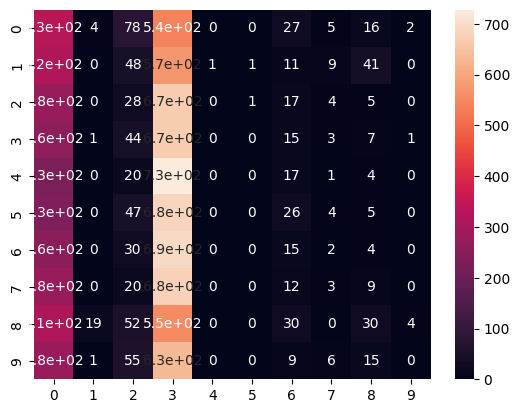

In [ ]:
from keras.models import load_model
# load the model
disc_sup_trained_model = load_model('disc_sup_5000.h5')

# load the dataset
(_, _), (testX, testy) = load_data()

# expand to 3d, e.g. add channels
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

# evaluate the model
_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)

#prediction and image generation

1/1 [==============================] - 0s 128ms/step


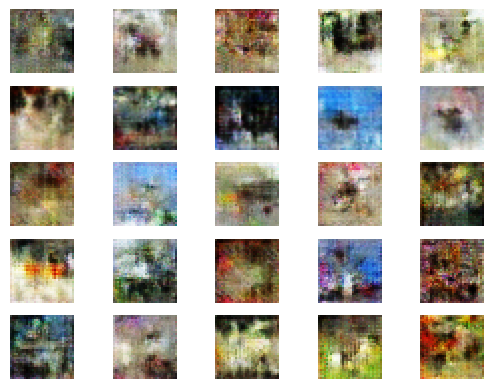

In [ ]:
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()

# load model
gen_trained_model = load_model('gen_model_5000.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = gen_trained_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)